In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from joblib import load, dump
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from torchvision import models as md
from torch import nn
from torch.nn import functional as F
import re
import math
import collections
from functools import partial
from torch.utils import model_zoo
from sklearn import metrics
from collections import Counter
import json
from efficientnet_pytorch import EfficientNet
from utils import *

In [3]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
SEED = 2019
seed_everything(SEED)

In [4]:
current_time = get_BJ_time()
print(current_time)

0903_01-03-41


# Reading data and Basic EDA(Exploratory Data Analysis)

Here I am going to open the dataset with pandas, check distribution of labels.

In [5]:
df_2019_cv = pd.read_csv('../input/aptos-data-split/df_2019_cv.csv')

test_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')

In [6]:
bs = 24 #smaller batch size is better for training, but may take longer
sz = 256  # get model input size
# sz = EfficientNet.get_image_size(model_name)  # get model input size
tfms = get_transforms(do_flip=True,flip_vert=True, max_rotate=0, max_zoom=1.2, max_warp=0)

# Training (Transfer learning)
The Kaggle competition used the Cohen's quadratically weighted kappa so I have that here to compare. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fastai uses.

In [7]:
def qk(y_pred, y):
    k = torch.tensor(cohen_kappa_score(torch.round(y_pred), y, weights='quadratic'), device='cuda:0')
    k[k != k] = 0
    k[torch.isinf(k)] = 0
    
    return k

## Fold 1

In [ ]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid1")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b5_0812_22-06-45_stage1")

In [ ]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [ ]:
model_save_name = "{}_{}_stage2_f1".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 8e-7, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.load(model_save_name)

## Fold 2

In [8]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid2")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b5_0902_04-26-49_stage1")
print("Reload")

Loaded pretrained weights for efficientnet-b5
Reload


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.29E-07


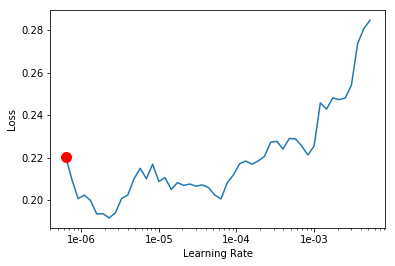

In [13]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [14]:
model_save_name = "{}_{}_stage2_f2".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 1e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

epoch,train_loss,valid_loss,qk,time
0,0.240993,0.223846,0.868436,00:55
1,0.233788,0.224082,0.868068,00:55
2,0.258126,0.223755,0.868068,00:55
3,0.237537,0.223823,0.868068,00:55
4,0.241148,0.223723,0.868436,00:56
5,0.227877,0.224696,0.867569,00:55
6,0.223227,0.224812,0.868948,00:56
7,0.221751,0.225059,0.868948,00:55


/home/ai/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:576: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


Better model found at epoch 0 with valid_loss value: 0.22384603321552277.
Better model found at epoch 2 with valid_loss value: 0.22375503182411194.
Better model found at epoch 4 with valid_loss value: 0.22372251749038696.
Epoch 8: early stopping
Model save as: efficientnet-b5_0903_01-03-41_stage2_f2


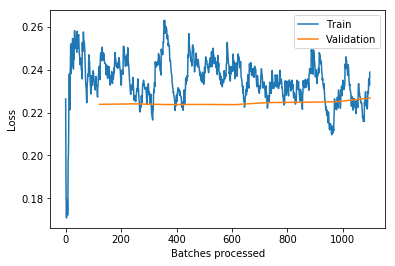

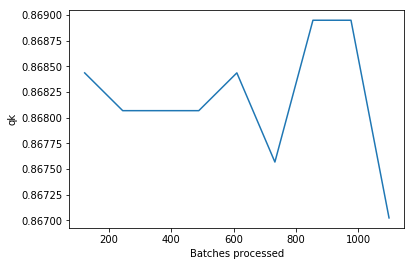

In [15]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [16]:
learn.load(model_save_name)
print("Reload", model_save_name)

Reload efficientnet-b5_0903_01-03-41_stage2_f2


## Fold 3

In [ ]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid3")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b5_0812_22-06-45_stage1")

In [ ]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [ ]:
model_save_name = "{}_{}_stage2_f3".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 1e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.load(model_save_name)

## Fold 4

In [ ]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid4")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b5_0812_22-06-45_stage1")

In [ ]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [ ]:
model_save_name = "{}_{}_stage2_f4".format(model_name, current_time)
# min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, 1e-6, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.load(model_save_name)

## Fold 5

In [ ]:
data1 = (ImageList.from_df(df=df_2019_cv,path='../input/aptos2019-blindness-detection',cols='id_code', folder='train_images_ben_preprocessing_sigmaX10', suffix='.png')
        .split_from_df("is_valid5")
        .label_from_df(cols='diagnosis',label_cls=FloatList) 
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros') 
        .databunch(bs=bs,num_workers=4) 
        .normalize(imagenet_stats)  
       )

model_name = 'efficientnet-b5'
model = EfficientNet.from_pretrained(model_name, num_classes=1)

learn = Learner(data1, 
                model, 
                path = ".",
                metrics = [qk],
                callback_fns=[partial(EarlyStoppingCallback, min_delta=0, patience=3)],
                model_dir = '../output/models/')

learn.data.add_test(ImageList.from_df(test_df,
                                      '../input/aptos2019-blindness-detection',
                                      folder='test_images_ben_preprocessing_sigmaX10',
                                      suffix='.png'))

learn.load("efficientnet-b5_0812_22-06-45_stage1")

In [ ]:
# Explore lr from `start_lr` to `end_lr` over `num_it` iterations in `learn`. If `stop_div`, stops when loss diverges.
learn.lr_find() 
learn.recorder.plot(suggestion=True)

In [ ]:
model_save_name = "{}_{}_stage2_f5".format(model_name, current_time)
min_grad_lr = learn.recorder.min_grad_lr
learn.fit_one_cycle(40, min_grad_lr, callbacks=[SaveModelCallback(learn, every='improvement', name=model_save_name)])
print("Model save as:", model_save_name)

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.load(model_save_name)

In [ ]:
learn.export("../output/inference/{}.pkl".format(model_save_name))

# Submission

## Fold 1

In [ ]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Fold 2

../output/submission/efficientnet-b5_0903_01-03-41_stage2_f2.csv done


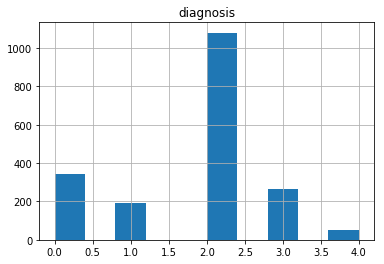

In [18]:
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = np.round(preds.numpy())
test_df.diagnosis = tst_pred.astype(int)

save_filename = '../output/submission/{}.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

## Fold 3

In [ ]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Fold 4

In [ ]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)

## Fold 5

In [ ]:
optR = OptimizedRounder()
preds,y = learn.get_preds(DatasetType.Test)
tst_pred = optR.predict(preds, [0.5, 1.5, 2.5, 3.5])
test_df.diagnosis = tst_pred.astype(int)

save_filename = '{}_submition.csv'.format(model_save_name)
test_df.to_csv(save_filename,index=False)
print (save_filename, 'done')

test_df.hist()
plt.show()

old.diagnosis.corr(test_df.diagnosis)